<a href="https://colab.research.google.com/github/vicente-gonzalez-ruiz/MCDWT-experimentos/blob/master/src/MDWT_1_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RD in the MDWT (Motion Discrete Wavelet Transform) domain

In [11]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.axes as ax
import math
import numpy as np
from scipy import signal
import cv2
import os
import pywt
import pylab

In [12]:
def quantizer(x, quantization_step):
    k = (x / quantization_step).astype(np.int16)
    return k

def dequantizer(k, quantization_step):
    y = quantization_step * k
    return y

def q_deq(x, quantization_step):
    k = quantizer(x, quantization_step)
    y = dequantizer(k, quantization_step)
    return k, y

In [13]:
def load_frame(prefix):
    fn = f"{prefix}.png"
    print(fn)
    frame = cv2.imread(fn, cv2.IMREAD_UNCHANGED) # [rows, columns, components]
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = np.array(frame)
    frame = frame.astype(np.float32) - 32768.0
    return frame

def write_frame(frame, prefix):
    frame = frame.astype(np.float32)
    frame += 32768.0
    frame = frame.astype(np.uint16)
    cv2.imwrite(f"{prefix}.png", frame)
    
def load_indexes(prefix):
    load_frame(prefix)
    
def write_indexes(prefix):
    write_frame(prefix)

In [14]:
def normalize(img):
    max_component = np.max(img)
    min_component = np.min(img)
    max_min_component = max_component - min_component
    return (img-min_component)/max_min_component

def show_frame(frame, prefix):
    frame = normalize(frame)
    plt.figure(figsize=(10,10))
    plt.title(prefix, fontsize=20)
    plt.imshow(frame)

In [15]:
def average_energy(x):
    return np.sum(x.astype(np.double)*x.astype(np.double))/len(x)

def MSE(x, y):
    error_signal = x - y
    return average_energy(error_signal)

def RMSE(x, y):
    error_signal = x - y
    return math.sqrt(MSE(error_signal))

def bytes_per_frame(frame):
    write_frame(frame, "/tmp/frame")
    length_in_bytes = os.path.getsize("/tmp/frame.png")
    return length_in_bytes

In [16]:
def RGB_to_YCoCg(RGB_frame):
    R, G, B = RGB_frame[:,:,0], RGB_frame[:,:,1], RGB_frame[:,:,2]
    YCoCg_frame = np.empty_like(RGB_frame)
    YCoCg_frame[:,:,0] =  R/4 + G/2 + B/4 
    YCoCg_frame[:,:,1] =  R/2       - B/2
    YCoCg_frame[:,:,2] = -R/4 + G/2 - B/4
    return YCoCg_frame

def YCoCg_to_RGB(YCoCg_frame):
    Y, Co, Cg = YCoCg_frame[:,:,0], YCoCg_frame[:,:,1], YCoCg_frame[:,:,2]
    RGB_frame = np.empty_like(YCoCg_frame)
    RGB_frame[:,:,0] = Y + Co - Cg 
    RGB_frame[:,:,1] = Y      + Cg
    RGB_frame[:,:,2] = Y - Co - Cg
    return RGB_frame

In [17]:
WAVELET = pywt.Wavelet("db5")
#WAVELET = pywt.Wavelet("bior3.5")
N_LEVELS = 3

def color_DWT_analyze(color_frame, wavelet=WAVELET, n_levels=N_LEVELS):
    n_channels = color_frame.shape[2]
    color_decomposition = [None]*n_channels
    for c in range(n_channels):
        color_decomposition[c] = pywt.wavedec2(data=color_frame[:,:,c], wavelet=wavelet, mode='per', level=n_levels)
    return color_decomposition # A list of "gray" decompositions

def color_DWT_synthesize(color_decomposition, wavelet=WAVELET):
    n_channels = len(color_decomposition)
    #n_levels = len(color_decomposition[0])-1
    # color_decomposition[0] <- First channel
    # color_decomposition[0][0] <- cAn (lowest frequecy subband) of the first channel
    # color_decomposition[0][1] <- (cHn, cVn, cDn) (lowest high-frequency subbands) of the first channel
    # color_decomposition[0][1][0] <- cHn (LH subband) of the first channel
    # See https://pywavelets.readthedocs.io/en/latest/ref/2d-dwt-and-idwt.html#d-multilevel-decomposition-using-wavedec2
    _color_frame = []
    for c in range(n_channels):
        frame = pywt.waverec2(color_decomposition[c], wavelet=wavelet, mode='per')
        _color_frame.append(frame)
    n_rows = _color_frame[0].shape[0]
    n_columns = _color_frame[0].shape[1]
    color_frame = np.ndarray((n_rows, n_columns, n_channels), np.float64)
    for c in range(n_channels):
        color_frame[:,:,c] = _color_frame[c][:,:]
    return color_frame

In [18]:
def DWT_RD_curve(RGB_frame, n_levels=N_LEVELS):
    n_channels = RGB_frame.shape[2]
    RD_points = []
    for q_step in range(0, 8):
        YCoCg_frame = RGB_to_YCoCg(RGB_frame)
        YCoCg_decomposition = color_DWT_analyze(YCoCg_frame, n_levels=n_levels)
        dequantized_YCoCg_decomposition = []
        rate = 0
        for channel in range(n_channels):
            # In a channel there is a decomposition
            decomposition = YCoCg_decomposition[channel]
            cAn = decomposition[0]
            k, dequantized_cAn = q_deq(cAn, 1<<q_step)
            dequantized_decomposition = [dequantized_cAn]
            rate += bytes_per_frame(k)
            rest_of_resolutions = decomposition[1:]
            for resolution in rest_of_resolutions:
                # In a resolution there is/are one/three subbands
                dequantized_resolution = []
                for subband in resolution:
                    k, dequantized_subband = q_deq(subband, 1<<q_step)
                    rate += bytes_per_frame(k)
                    dequantized_resolution.append(dequantized_subband)
                dequantized_decomposition.append(tuple(dequantized_resolution))
            dequantized_YCoCg_decomposition.append(dequantized_decomposition)
        reconstructed_YCoCg_frame = color_DWT_synthesize(dequantized_YCoCg_decomposition)
        reconstructed_RGB_frame = YCoCg_to_RGB(reconstructed_YCoCg_frame)
        distortion = MSE(RGB_frame, reconstructed_RGB_frame)
        print(f"q_step={1<<q_step:>3}, rate={rate:>7} bytes, distortion={distortion:>6.1f}")
        RD_points.append((rate, distortion))
    return RD_points

In [19]:
RD_curves = []
for frame_number in range(5):
    fn = f"/home/soloelectronicos/MRVC/sequences/stockholm/{frame_number:03d}"
    print(fn)
    RGB_frame = load_frame(fn)
    RD_points = DWT_RD_curve(RGB_frame, n_levels=3)
    RD_curves.append(RD_points)

/home/soloelectronicos/MRVC/sequences/stockholm/000
/home/soloelectronicos/MRVC/sequences/stockholm/000.png
q_step=  1, rate=1493755 bytes, distortion=2371.0
q_step=  2, rate=1032779 bytes, distortion=7415.1
q_step=  4, rate= 664467 bytes, distortion=22309.0
q_step=  8, rate= 349217 bytes, distortion=62163.1
q_step= 16, rate= 171805 bytes, distortion=142662.7
q_step= 32, rate=  88702 bytes, distortion=301214.9
q_step= 64, rate=  49961 bytes, distortion=608645.6
q_step=128, rate=  32828 bytes, distortion=1251477.3
/home/soloelectronicos/MRVC/sequences/stockholm/001
/home/soloelectronicos/MRVC/sequences/stockholm/001.png
q_step=  1, rate=1494939 bytes, distortion=2370.6
q_step=  2, rate=1033131 bytes, distortion=7419.3
q_step=  4, rate= 665235 bytes, distortion=22310.4
q_step=  8, rate= 348966 bytes, distortion=62085.6
q_step= 16, rate= 171367 bytes, distortion=142455.6
q_step= 32, rate=  88591 bytes, distortion=300939.2
q_step= 64, rate=  49894 bytes, distortion=608080.5
q_step=128, rat

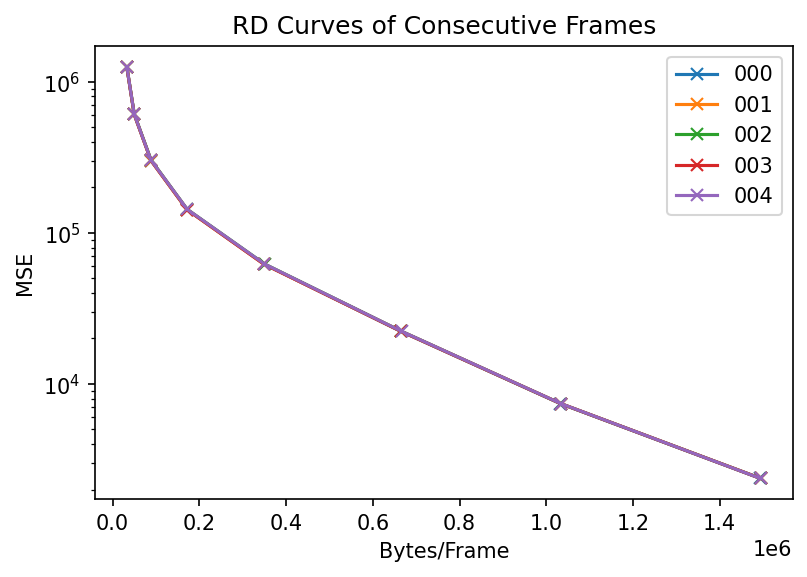

In [10]:
pylab.figure(dpi=150)
for frame_number in range(5):
    pylab.plot(*zip(*RD_curves[frame_number]), marker="x", label=f'{frame_number:03d}')
pylab.title("RD Curves of Consecutive Frames")
pylab.xlabel("Bytes/Frame")
pylab.ylabel("MSE")
plt.legend(loc='upper right')
plt.yscale('log')
#plt.xscale('log')
pylab.show()